In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# Homework
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

## dropout & regularizers

In [5]:
from keras.layers import Input, Dropout, BatchNormalization, Dense, Activation
from keras.models import Model
from keras.regularizers import l1_l2

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=(1e-2,1e-2)):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1),
                                   kernel_regularizer=l1_l2_ratio)(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1),
                                   kernel_regularizer=l1_l2_ratio)(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [7]:
l1_l2_ratio = [l1_l2(1e-2), l1_l2(1e-3), l1_l2(1e-4)]
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
drp_ratio = 0.5

In [8]:
results = {}
for l1l2 in l1_l2_ratio:
    keras.backend.clear_session()
    print('Experiment with l1l2_ratio: ' + str(l1l2.l1))
    model = build_mlp(input_shape = x_train.shape[1:], l1_l2_ratio = l1l2)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    model.fit(x_train, y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test, y_test),
              shuffle=True)
    # Collect results
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    
    exp_name_tag = 'l1l2_ratio' + str(str(l1l2.l1))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    

W0727 21:13:19.701085  1812 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0727 21:13:19.702574  1812 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0727 21:13:19.726882  1812 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 21:13:19.727897  1812 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use

Experiment with l1l2_ratio: 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)   

W0727 21:13:20.103219  1812 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 108us/step - loss: 370.9771 - acc: 0.1068 - val_loss: 303.6321 - val_acc: 0.1978
Epoch 2/50
50000/50000 [==============================] - 3s 60us/step - loss: 237.2312 - acc: 0.1289 - val_loss: 173.2028 - val_acc: 0.1886
Epoch 3/50
50000/50000 [==============================] - 3s 63us/step - loss: 125.3985 - acc: 0.1437 - val_loss: 82.6836 - val_acc: 0.1745
Epoch 4/50
50000/50000 [==============================] - 3s 69us/step - loss: 56.1758 - acc: 0.1407 - val_loss: 35.8271 - val_acc: 0.1759
Epoch 5/50
50000/50000 [==============================] - 4s 88us/step - loss: 28.0560 - acc: 0.1066 - val_loss: 21.8073 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 3s 68us/step - loss: 17.6592 - acc: 0.0990 - val_loss: 13.8883 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 3s 68us/step - loss: 11.0615 - acc: 0.1018 - val_los

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 87us/step - loss: 55.3572 - acc: 0.1047 - val_loss: 53.6649 - val_acc: 0.1281
Epoch 2/50
50000/50000 [==============================] - 3s 63us/step - loss: 51.9499 - acc: 0.1247 - val_loss: 50.1164 - val_acc: 0.1850
Epoch 3/50
50000/50000 [==============================] - 3s 64us/step - loss: 48.4292 - acc: 0.1380 - val_loss: 46.6546 - val_acc: 0.2054
Epoch 4/50
50000/50000 [==============================] - 3s 61us/step - loss: 45.0511 - acc: 0.1488 - val_loss: 43.3561 - val_acc: 0.2031
Epoch 5/50
50000/50000 [==============================] - 3s 66us/step - loss: 41.8424 - acc: 0.1590 - val_loss: 40.2241 - val_acc: 0.2198
Epoch 6/50
50000/50000 [==============================] - 3s 64us/step - loss: 38.7980 - acc: 0.1691 - val_loss: 37.2575 - val_acc: 0.2307
Epoch 7/50
50000/50000 [==============================] - 4s 75us/step - loss: 35.9112 - acc: 0.1762 - val_loss: 34.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 78us/step - loss: 20.1453 - acc: 0.1073 - val_loss: 19.6983 - val_acc: 0.1762
Epoch 2/50
50000/50000 [==============================] - 3s 63us/step - loss: 19.3754 - acc: 0.1308 - val_loss: 18.9997 - val_acc: 0.2173
Epoch 3/50
50000/50000 [==============================] - 3s 62us/step - loss: 18.6825 - acc: 0.1447 - val_loss: 18.3083 - val_acc: 0.2265
Epoch 4/50
50000/50000 [==============================] - 3s 62us/step - loss: 18.0107 - acc: 0.1572 - val_loss: 17.6371 - val_acc: 0.2442
Epoch 5/50
50000/50000 [==============================] - 3s 62us/step - loss: 17.3589 - acc: 0.1732 - val_loss: 16.9896 - val_acc: 0.2351
Epoch 6/50
50000/50000 [==============================] - 3s 63us/step - loss: 16.7293 - acc: 0.1789 - val_loss: 16.3653 - val_acc: 0.2502
Epoch 7/50
50000/50000 [==============================] - 3s 63us/step - loss: 16.1294 - acc: 0.1889 - val_loss: 15.

# BatchNormalization

In [9]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                  activation='relu',
                                  name='hidden_layer'+str(i+1))(input_layer)
        
        else:
            x = keras.layers.Dense(units=n_units,
                                  activation='relu',
                                  name='hidden_layer'+str(i+1))(x)
        # 在每層後加入BN層
        x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [11]:
keras.backend.clear_session()
print('Experiment with BatchNormalization')
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
model.fit(x_train, y_train,
          epochs = EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test, y_test),
          shuffle=True)
    
# Collect results
train_loss = model.history.history['loss']
valid_loss = model.history.history['val_loss']
train_acc = model.history.history['acc']
valid_acc = model.history.history['val_acc']
    
exp_name_tag = 'BatchNormalization'
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Experiment with BatchNormalization
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128) 

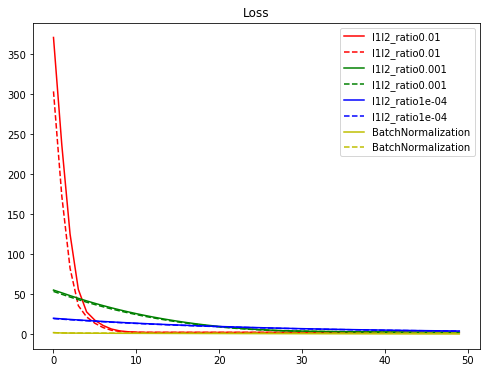

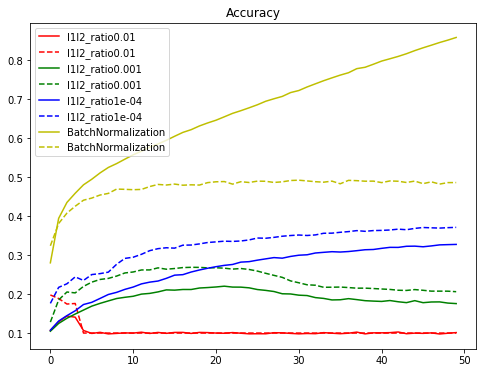

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()